In [2]:
import numpy as np
import pandas as pd
import sklearn
import pickle

import matplotlib.pyplot as plt
import cv2

In [3]:
### Load all models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml') # cascade classifier
model_svm = pickle.load(open('./model/model_svm.pickle',mode='rb')) # machine learning model (SVM)
pca_models = pickle.load(open('./model/pca_dict.pickle',mode='rb')) # pca dictionary

In [4]:
model_pca = pca_models['pca'] # PCA model
mean_face_arr = pca_models['mean_face'] # Mean face

In [5]:
### Create pipeline

In [39]:
#1: read image
img = cv2.imread('./test_images/getty_test.jpg')
#2: convert into gray scale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#3: crop the face (using haar cascase classifier)
faces = haar.detectMultiScale(gray,1.5,3)
predictions = []
for x,y,w,h in faces:
    roi = gray[y:y+h,x:x+w]
    #4: normalization
    roi = roi / 255.0
    #5: resize images (100,100)
    if roi.shape[1] > 100:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
    
    #6: Flattening (1x10000)
    roi_reshape = roi_resize.reshape(1,10000)   
    #7: subtract with mean
    roi_mean = roi_reshape - mean_face_arr # subtract face with mean face
    #8: get eigen image (apply roi_mean to pca)
    eigen_image = model_pca.transform(roi_mean) 
    #9: Eigne image for visualization
    eig_img = model_pca.inverse_transform(eigen_image)
    #10: pass to ml model (svm) and get predictions
    results = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
    #11: generate report
    text ="%s : %d"%(results[0],prob_score_max*100)
    #defining color based on results
    if results[0] == 'male':
        color = (255,255, 0)
    else:
        color = (255,0,255)
    cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color,-1)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_PLAIN,2.75,(255,255,255),5)
    output = {
        'roi':roi,
        'eig_img':eig_img,
        'prediction_name':results[0],
        'score':prob_score_max
    }
    predictions.append(output)

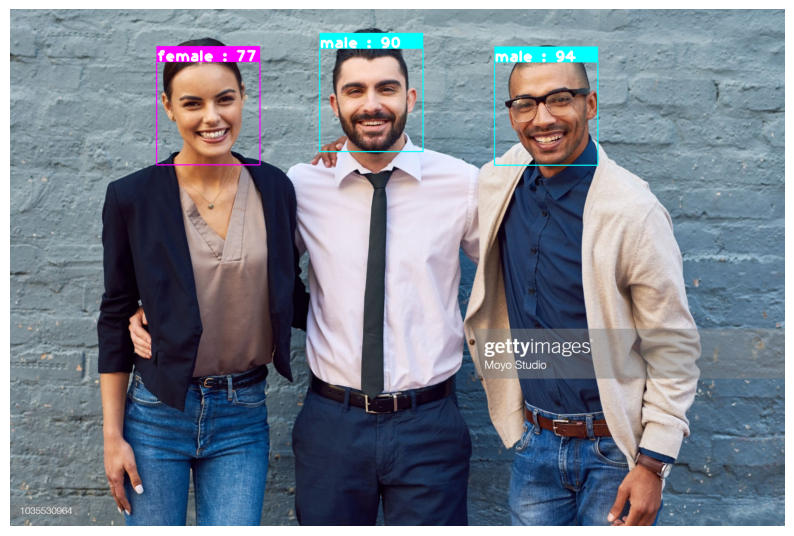

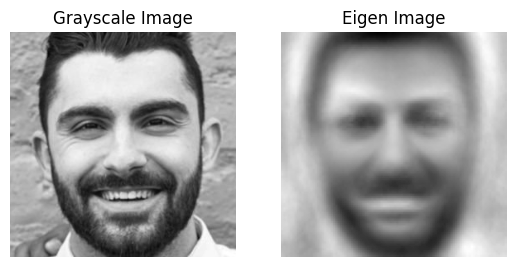

Predicted Gender = male
Predicted Score = 90.75 %
----------------------------------------------------------------------------------------------------


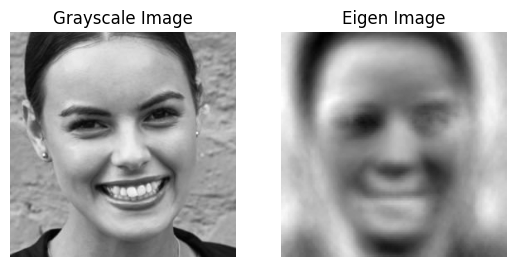

Predicted Gender = female
Predicted Score = 77.87 %
----------------------------------------------------------------------------------------------------


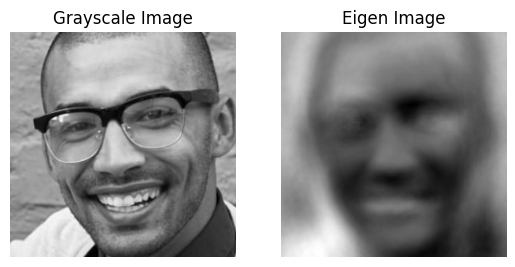

Predicted Gender = male
Predicted Score = 94.02 %
----------------------------------------------------------------------------------------------------


In [48]:
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## generate report
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi'] #gray scale
    obj_eig = predictions[i]['eig_img'].reshape(100,100) #eigen image
    plt.subplot(1,2,1)
    plt.imshow(obj_gray,cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(obj_eig,cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')

    plt.show()
    print('Predicted Gender =', predictions[i]['prediction_name'])
    print('Predicted Score = {:,.2f} %'.format(predictions[i]['score']*100))

    print('-'*100)